In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from clean_data import *

## Clean data and dimension reduction

In [76]:
# Prepare data for person 4. Use sequence 1~3 for training, 4~5 for testing.
person = 4
sadl_n = []
for n in range(1, 6):
    sadl_n.append(pd.read_table('data/S%d-ADL%d.dat' % (person, n), sep='\s+', header=None, dtype=float))

In [77]:
# Smooth data, time: col 0, features: col 1~36, labels: col 244 
winsize = 15
stepsize = 8

# train data
train_sample = np.empty((0, 36))
train_labels = np.empty((0))
train_len = []
for i in range(0, 3):
    features = moving_avg(sadl_n[i].iloc[:, 1:37], winsize, stepsize)
    labels = moving_vote_majority(sadl_n[i].iloc[:, 244], winsize, stepsize)
    train_sample = np.concatenate((train_sample, features), axis=0)
    train_len.append(features.shape[0])
    train_labels = np.concatenate( (train_labels, labels) )
train_len = np.array(train_len)

print "train_sample size: ", train_sample.shape
print "train_labels size: ", train_labels.shape
print "subsequence length: ", train_len, ". Sum of length: ", np.sum(train_len)

# test data
test_sample = np.empty((0, 36))
test_labels = np.empty((0))
test_len = []
for i in range(3, 5):
    features = moving_avg(sadl_n[i].iloc[:, 1:37], winsize, stepsize)
    labels = moving_vote_majority(sadl_n[i].iloc[:, 244], winsize, stepsize)
    test_sample = np.concatenate((test_sample, features), axis=0)
    test_len.append(features.shape[0])
    test_labels = np.concatenate( (test_labels, labels) )
test_len = np.array(test_len)  

print "test_sample size: ", test_sample.shape
print "test_labels size: ", test_labels.shape
print "subsequence length: ", test_len, ". Sum of length: ", np.sum(test_len)


train_sample size:  (11806, 36)
train_labels size:  (11806,)
subsequence length:  [5198 3467 3141] . Sum of length:  11806
test_sample size:  (6593, 36)
test_labels size:  (6593,)
subsequence length:  [2778 3815] . Sum of length:  6593


In [78]:
# Fill missing values
col_threshold = 0.5
train, test = fill_missing(train_sample, test_sample, col_threshold, True)
np.any(np.isnan(train)), np.any(np.isnan(test))

(False, False)

In [79]:
# Normalize features
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler() # center to mean and normalize to unit variance
train_normalized = scalar.fit_transform(train)
test_normalized = scalar.fit_transform(test)

In [80]:
# Dimension reduction
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(train_normalized)
var_thres = 0.95 # keep components to up to 95% total variance
n_comp = (pca.explained_variance_ratio_.cumsum() < var_thres).sum() + 1
print "Keep %d compoments to retrain %f variance" % (n_comp, var_thres)

pca_train = PCA(n_components=n_comp)
train_reduced = pca_train.fit_transform(train_normalized)
test_reduced = pca_train.transform(test_normalized)
print "Size of reduced dimension training data: ", train_reduced.shape
print "Size of reduced dimension testing data: ", test_reduced.shape
# Cleaned data: train_reduced, test_reduced, train_labels, test_labels, train_len, test_len

Keep 22 compoments to retrain 0.950000 variance
Size of reduced dimension training data:  (11806, 22)
Size of reduced dimension testing data:  (6593, 22)


## Initialize upper level left-right hmm model with 6 states

In [81]:
from hmm import DiscreteDistr, GaussDistr, GaussMixDistr
from hmm import MarkovChain
from hmm import HMM, make_leftright_hmm

# Build a left-right hmm with 6 states, discrete output distribution, the output is the discrete label of activity
label_transfer = (np.maximum(train_labels - 100, 0) + 1)[:, np.newaxis]
# transform the labels into range 1~6. {0: 1, 101: 2, 102: 3, 103: 4, 104: 5, 105: 6}
discreteD = DiscreteDistr(np.ones((6))) # a discrete distribution with 6 possible output
n_states = 6

hmm_state = make_leftright_hmm(n_states, discreteD, obs_data=label_transfer, l_data=train_len)
print "Probability mass P(label | state): "
prob_mass = np.zeros((n_states, n_states))
for i in range(0, n_states):
    prob_mass[i, :] = hmm_state.output_distr[i].prob_mass
prob_mass[prob_mass < 1e-2] = 0
for i in range(0, n_states):
    hmm_state.output_distr[i].prob_mass = prob_mass[i, :]
print prob_mass

# Assign max probability activity label to each state
# If multiple states are assigned with one same label, then inside each of these states use a small hmm 
state_act_label = np.array([np.argmax(prob_mass[i, :]) for i in range(0, n_states)])
act_label_count = np.zeros((n_states)) # how many states correspond to label i
for i in range(0, n_states):
    act_label_count[i] = np.sum(state_act_label == i)
print "The maximum likelihood label for each state: "
print state_act_label

Probability mass P(label | state): 
[[ 0.82215481  0.17784519  0.          0.          0.          0.        ]
 [ 0.01197513  0.          0.          0.98802487  0.          0.        ]
 [ 0.05644644  0.          0.94355356  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.99999999]
 [ 0.03358826  0.          0.          0.          0.96641174  0.        ]
 [ 0.7703183   0.2296817   0.          0.          0.          0.        ]]
The maximum likelihood label for each state: 
[0 3 2 5 4 0]


In [82]:
# Train output distribution
def search_num_mixtures_likelihood(features, train_len, n_mix):
    # Use cross validation on loglikehood to find the optimal number of mixtures for each class label
    # return: 
    # gmm: the gmm model that gives the highest mean logprob
    # N: number of gaussian mixtures in the gmm
    # logp_x: mean of logP(Xt | gmm) for the chosen gmm
    mean_logprob = [0 for i in range(0, len(n_mix))] # mean of logP(Xt | gmm)
    start_ind = [0] + list(np.cumsum(train_len)[:-1].astype(int))
    for i, N in enumerate(n_mix):
        # K-fold cross validataion, each fold is one subsequence
        n_folds = len(train_len)
        likelihood_scores = []
        for k in range(0, n_folds):
            val_mask = np.zeros((features.shape[0])).astype(bool)
            val_mask[start_ind[k]: start_ind[k] + train_len[k]] = True
            train_mask = np.logical_not(val_mask)
            gmm = GaussMixDistr(gauss=N)
            gmm.init_by_data(features[train_mask, :])
            gmm.train(features[train_mask, :])
            logprob_x = gmm.logprob(features[val_mask, :])
            likelihood_scores.append(np.mean(logprob_x))    
        mean_logprob[i] = np.mean(likelihood_scores)
    # Refit gmm using all data with selected number of mixtures
    gmm_list = [] # one gmm model for each "number of components"
    i_gmm = np.argmax(mean_logprob)
    n_components = n_mix[i_gmm]
    gmm_opt = GaussMixDistr(gauss=n_components)
    gmm_opt.init_by_data(features)
    gmm_opt.train(features)
    likelihood_score = np.mean(gmm_opt.logprob(features))
    return gmm_opt, n_components, likelihood_score

def make_outputdistr(train, train_len, train_labels, class2label):
    outputdistr_stats = pd.DataFrame(index=class2label, columns=['n_mixture', 'mean_loglikelihood'])
    outputdistr_gmm = []
    n_mix = range(1, 11)
    start_ind = [0] + list(np.cumsum(train_len)[:-1].astype(int))
    for i, label in enumerate(class2label):
        per_label_trainlen = [sum(train_labels[start_ind[k]: start_ind[k] + length] == label) for k, length in enumerate(train_len)]
        gmm, N, logprob = search_num_mixtures_likelihood(train[train_labels == label], per_label_trainlen, n_mix)
        outputdistr_gmm.append(gmm)
        outputdistr_stats.iloc[i, :] = [N, logprob]
    return outputdistr_gmm, outputdistr_stats

class2label = [0, 101, 102, 103, 104, 105]
outputdistr_gmm, outputdistr_stats = make_outputdistr(train_reduced, train_len, train_labels, class2label)
outputdistr_stats

,n_mixture,mean_loglikelihood
0,9,-13.48975
101,1,-37.14691
102,2,-25.4434
103,2,-19.11997
104,2,-30.29331
105,8,-23.86709


In [83]:
def loglikelihood(mc, x, prob_mass, gmms):
    """
    Compute log likelihood for each observation sample given the MarkovChain of top-layer hmm, 
    and gmm distribution P(X(t) | activity label = i).
    Input:
    mc: MarkovChain for top-layer hmm. 
    prob_mass: probability mass for output distribution of top-layer hmm. 
               prob_mass[i, j] = P[activity_label = j | S_{hmm_top} = i]
    gmms: list of gmm object. gmms[i] has P(X(t) | activity_label = i)
    Return:
    logp_x: [n_states, n_samples]. logp_x[i, t] = log P[X(t) | S_{hmm_top} = i]
    Method:
    Compute: P(X(t) | state = i ) for t = 0...T, i = 0...5,
    P(X(t) | state = i ) = \sum_{label i} P(X(t) | label = j, state = i) * P(label = j | state = i)
    """
    T = x.shape[0]
    n_states = mc.n_states
    logp_x = np.zeros((n_states, T))
    for state in range(0, mc.n_states):
        label_ind = np.argwhere(prob_mass[state, :] > 0)
        p0 = prob_mass[state, prob_mass[state, :] > 0]
        logprob_per_label = gmms[0].logprob(x, [gmms[i] for i in label_ind])
        logp_x[state, :] = np.log( p0[np.newaxis, :].dot(np.exp(logprob_per_label)) )[0, :]

    return logp_x

In [84]:
def viterbi_state_sequence(mc, x, x_len, prob_mass, gmms):
    """
    Predict top-layer hmm state sequence using viterbi algorithm.
    Input
    x: [T, data_size]. vector sequence stacked together
    x_len: length of subsequences
    mc:        MarkovChain for top-layer hmm.
    prob_mass: probability mass for output distribution of top-layer hmm. 
               prob_mass[i, j] = P[activity_label = j | S_{hmm_top} = i]
    gmms:      list of gmm object. gmms[i] has P(X(t) | activity_label = i)
    Return:
    s_opt: [T, ] predicted top-layer hmm state sequence
    logP: [n_seq, ] logP of each subsequence
    """
    start_ind = 0
    s_opt = np.zeros((x.shape[0]))
    logP = np.zeros((len(x_len)))
    for i in range(0, len(x_len)):
        logp_x = loglikelihood(mc, x[start_ind:start_ind + x_len[i], :], prob_mass, gmms)
        s_opt[start_ind: start_ind + x_len[i]], logP[i] = mc.viterbi(logp_x)
        start_ind += x_len[i]
    return s_opt - 1, logP # the state sequence index from 0

In [85]:
# Predict label within each state
# Make an ergordic hmm with output distribution 1.0, (1-to-1 mapping between label and substate)

train_states, _ = hmm_state.viterbi(label_transfer)
train_states -= 1
# train_states, _ = viterbi_state_sequence(hmm_state.state_gen, train_reduced, train_len, prob_mass, outputdistr_gmm)

In [86]:
def make_sub_hmm(train_states, train_len, train_labels, n_states):
    """
    Initialize and train the sub-layer hmm for each top-layer hmm state.
    For the sub-layer hmm, each state corresponds to one activity label. 
    We train the transition prob by running Baum-Weltch EM training, by initializing the output 
    probability mass as the diagonal matrix, to force one to one mapping between sub-layer state and label.
    Input:
    train_states: [n_samples, ]. Sequence of top-layer hmm states.
    train_len: list. Length of subsequences.
    train_labels: [n_samples, ]. Activity labels of training sequence. The range of each label must be in [0, n_states)
    Return:
    mc_per_state: list of MarkovChain objects. mc_per_state[i] is the MarkovChain for top-layer state i. 
    """
    train_labels = train_labels[:, np.newaxis]
    start_ind = [0] + list(np.cumsum(train_len)[:-1].astype(int))
    mc_per_state = []
    for n in range(0, n_states):
        x_labels = train_labels[train_states == n, :]
        x_len = np.array([np.sum(train_states[s:s + train_len[i]] == n) for i, s in enumerate(start_ind)])
        x_len = x_len[x_len > 0]
        # Aii = 1 - 1/state_duration, Aij = 1/state_duration / (n_states_actual - 1)
        A0 = np.eye((n_states))
        D = np.array([np.sum(x_labels == i) / float(len(x_len)) for i in range(0, n_states)])
        n_states_actual = np.sum(D > 0)
        for i in range(0, n_states):
            if D[i] == 0:
                continue
            A0[i, D > 0] = 1.0 / D[i] / n_states_actual
            A0[i, i] = 1.0 - 1.0 / D[i]
        p0 = np.ones((n_states)) / float(n_states_actual)
        p0[D == 0] = 0.0
        prob_mass = np.eye((n_states))
        pD = [DiscreteDistr(prob_mass[i, :]) for i in range(0, n_states)]
        mc = MarkovChain(p0, A0)
        hmm_mc = HMM(mc, pD)
        hmm_mc.train(obs_data=x_labels + 1, l_data=x_len) # discrete distribution index from 1 
        mc_per_state.append(hmm_mc.state_gen)
        
    return mc_per_state
    
sub_mcs = make_sub_hmm(train_states, train_len, np.maximum(0, train_labels - 100), 6)

In [87]:
# Predict activity labels inside each high-level hmm state
def predict_subhmm_labels(level_one_states, obs_data, l_data, sub_mcs, outputdistr):
    # Input:
    # level_one_states: [n_samples, ]. Sequences of states of high level hmm.
    # obs_data: [n_samples, n_features]
    # l_data: length of sequences. sum(l_data) = len(level_one_states)
    # sub_mcs: MarkovChain objects for each high-level state. The order of states in the mc corresponds to the low-level label.
    # outputdistr: the output distribution for the states in sub_mcs.
    # Return:
    # labels_opt: [n_samples, ]. predicted labels
    start_ind = [0] + list(np.cumsum(l_data)[:-1].astype(int))
    labels_opt = np.zeros((level_one_states.shape[0]))
    cur_pos = 0
    for t in range(0, len(l_data)):
        state_subseq = level_one_states[start_ind[t]:start_ind[t] + l_data[t]]
        obs_subseq = obs_data[start_ind[t]:start_ind[t] + l_data[t], :]
        diff = np.append(np.array([1]), state_subseq[1:] - state_subseq[:-1])
        i_newstate = np.append( np.argwhere(diff != 0), np.array([len(diff)]) )
        for m in range(0, len(i_newstate) - 1):
            state_tt = int(state_subseq[i_newstate[m]])
            obs_tt = obs_subseq[i_newstate[m]:i_newstate[m + 1], :]
            # run viterbi on markov chain sub_mcs[state_tt]
            logp_x = outputdistr[0].logprob(obs_tt, outputdistr)
            labels_tt, logP = sub_mcs[state_tt].viterbi(logp_x)
            labels_opt[cur_pos:cur_pos + len(labels_tt)] = labels_tt - 1 # make the label index starting from 0
            cur_pos += len(labels_tt)
    return labels_opt   

# Predict test labels
test_states, _ = viterbi_state_sequence(hmm_state.state_gen, test_reduced, test_len, prob_mass, outputdistr_gmm)
predicted_labels = predict_subhmm_labels(test_states, test_reduced, test_len, sub_mcs, outputdistr_gmm)

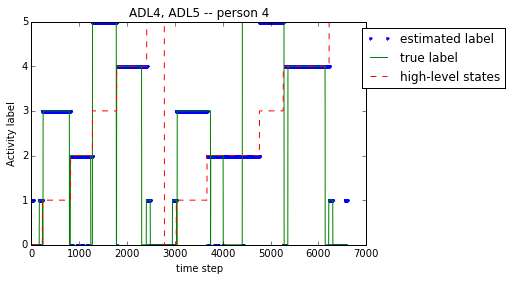

accuracy:  0.800242681632


In [88]:
# Test with ADL4, ADL5
true_labels = np.maximum(0, test_labels - 100)

plt.plot(predicted_labels, '.', label="estimated label")
plt.plot(true_labels, '-', label="true label")
plt.plot(test_states, '--', label="high-level states")
plt.xlabel('time step')
plt.ylabel('Activity label')
plt.title("ADL4, ADL5 -- person %d" % person)
plt.legend(loc=9, bbox_to_anchor=(1.2, 1))
plt.show()

print "accuracy: ", sum(predicted_labels == true_labels) / float(len(true_labels))

In [89]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
print "Weighted F1 score: ", f1_score(true_labels, predicted_labels, average='weighted') 

precision, recall , _, _ = precision_recall_fscore_support(true_labels, predicted_labels, average=None, labels=[0, 1, 2, 3, 4, 5])
pr_table = pd.DataFrame(index=range(0, 6), columns=['precision', 'recall'])
for i in range(0, n_states):
    pr_table.iloc[i, :] = [precision[i], recall[i]]
pr_table

Weighted F1 score:  0.805945762705


,precision,recall
0,0.8995943,0.5346594
1,0.8498498,0.876161
2,0.4260753,0.9215116
3,0.9545085,0.9407526
4,0.8382732,0.999232
5,0.9930209,0.7259475
